In [1]:
# Import whole libraries
import tweepy
import nltk
import collections
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Import specfic functions from library
from nltk.tokenize import TweetTokenizer
from nltk.corpus.reader import TwitterCorpusReader
from nltk.stem import SnowballStemmer

from yellowbrick.text import TSNEVisualizer
from pprint import pprint

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline

# Home-made modules and functions
from utils import visualize, cluster_information

# For Jupyter notebook usage
from IPython.display import display, HTML


# External loading!
%load_ext autoreload
%autoreload 2

In [35]:
class NLTKStemmer(BaseEstimator, TransformerMixin):
    def __init__(self, stemmer=SnowballStemmer):
        self.stemmer = stemmer('english')
                
    def stem(self, tweet):
        for token in tweet.split(' '):
            yield self.stemmer.stem(token).replace(' ', '')
            
    def fit(self, X, y=None):
        return self
    
    def transform(self, tweets):
        if type(tweets) is str:
            print('Hei')
            warnings.warn('Single Tweet passed as string')
        for tweet in tweets:
            stemmed = ' '.join(self.stem(tweet))
            yield stemmed
            
class DenseTransformer(TransformerMixin):
    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [42]:
# Create a pipeline specific for the MDS manifold dim reducer.
mds_pipe = Pipeline([
    ('denseify', DenseTransformer()),
    ('MDS', MDS())
])


# Create model for clustering
cluster_model = Pipeline([
    ('preprocessor', Pipeline([
        ('stemmer', NLTKStemmer()),
        ('stopword', 'passthrough'),
        ('lemmatization', 'passthrough'),
    ])),
    ('vectorizer', TfidfVectorizer(tokenizer=TweetTokenizer().tokenize,
                                   stop_words='english',
                                   ngram_range=(2, 3))),
    ('cluster', KMeans(n_jobs=3, n_clusters=4, n_init=30))
])

dim_reduction_model = Pipeline([
    ('preprocessor', Pipeline([
        ('stemmer', NLTKStemmer()),
        ('stopword', 'passthrough'),
        ('lemmatization', 'passthrough'),
    ])),
    ('vectorizer', TfidfVectorizer(tokenizer=TweetTokenizer().tokenize,
                                   stop_words='english',
                                   ngram_range=(2, 3))),
    ('dim_reduction', mds_pipe)
])

In [43]:
cluster_model.named_steps['vectorizer']

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(2, 3), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words='english', strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=<bound method TweetTokenizer.tokenize of <nltk.tokenize.casual.TweetTokenizer object at 0x7fc17fc82f90>>,
                use_idf=True, vocabulary=None)


Cluster 0:… rt, : “, rt @hmtreasury, rt @hmtreasury :, @hmtreasury :, . …, @hmtreasury : “, social care, … rt @hmtreasury, bori johnson, spend round, year ., prime minist, deal ., £ 1.5, 

Cluster 1:… rt, bori johnson, today ., rt @conservatives :, @conservatives :, rt @conservatives, : ", : great, t …, , …, . rt, no-deal brexit, brexit ., general elect, : labour, 

Cluster 2:… rt, : today, bori johnson, rt @jeremycorbyn, @jeremycorbyn :, rt @jeremycorbyn :, : ., disastr deal, : tonight, @jeremycorbyn : today, #pmqs ., prime minister, today spend, minister ,, today #pmqs, 

Cluster 3:discrimination , appreci, discrimination ,, , appreci, experienc racism discrimination, @tandhesi : experienc, racism discrimination, racism discrimination ,, felt muslim, experienc racism, felt muslim women, muslim women ,, pain felt, pain felt muslim, hurt pain felt, , appreci hurt, 


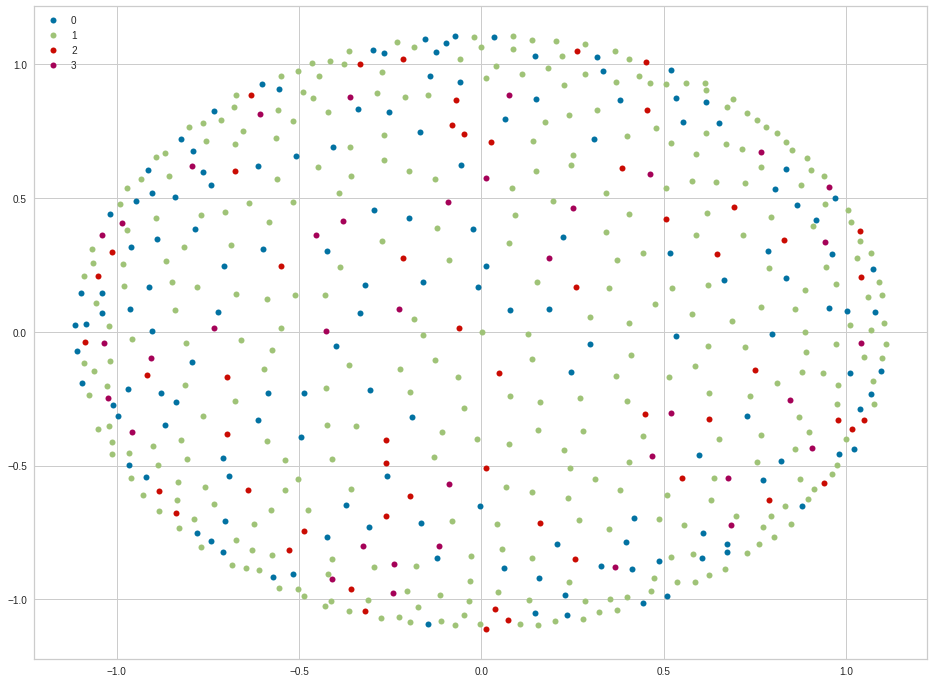

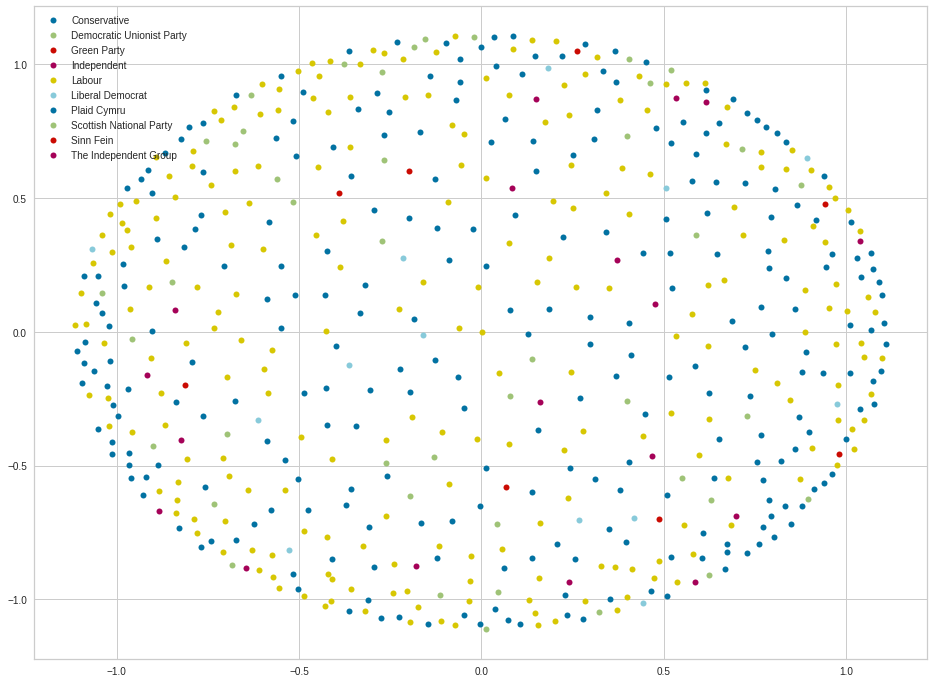

In [44]:
df = pd.read_pickle('corpus/user_df.pkl')
df['label'] = cluster_model.fit_predict(df['text'])
pos= dim_reduction_model.fit_transform(df['text'])
df['posx'], df['posy'] = pos[:, 0], pos[:, 1]

cluster_information(df, cluster_model.named_steps['vectorizer'],
                    cluster_model.named_steps['cluster'], num_words=20,
                    show_users=False)

visualize(df, marker_labels=False)
visualize(df, color_by='party', marker_labels=False)
plt.show()